# Channel Flow (Steady) DEMO code

This notebook demonstrates solving steady-state channel flow (uniform inlet) using Physics-Informed Neural Networks (PINNs).

In [93]:
from deepflow import PINN, Geometry, Physics, NetworkTrainer, Evaluate, ProblemDomain

## 1. Define Geometry Domain
Set up the computational domain: a rectangle with a circular obstacle (cylinder). This defines the area for simulation.

In [94]:
rectangle = Geometry.rectangle([0,1], [0,1])

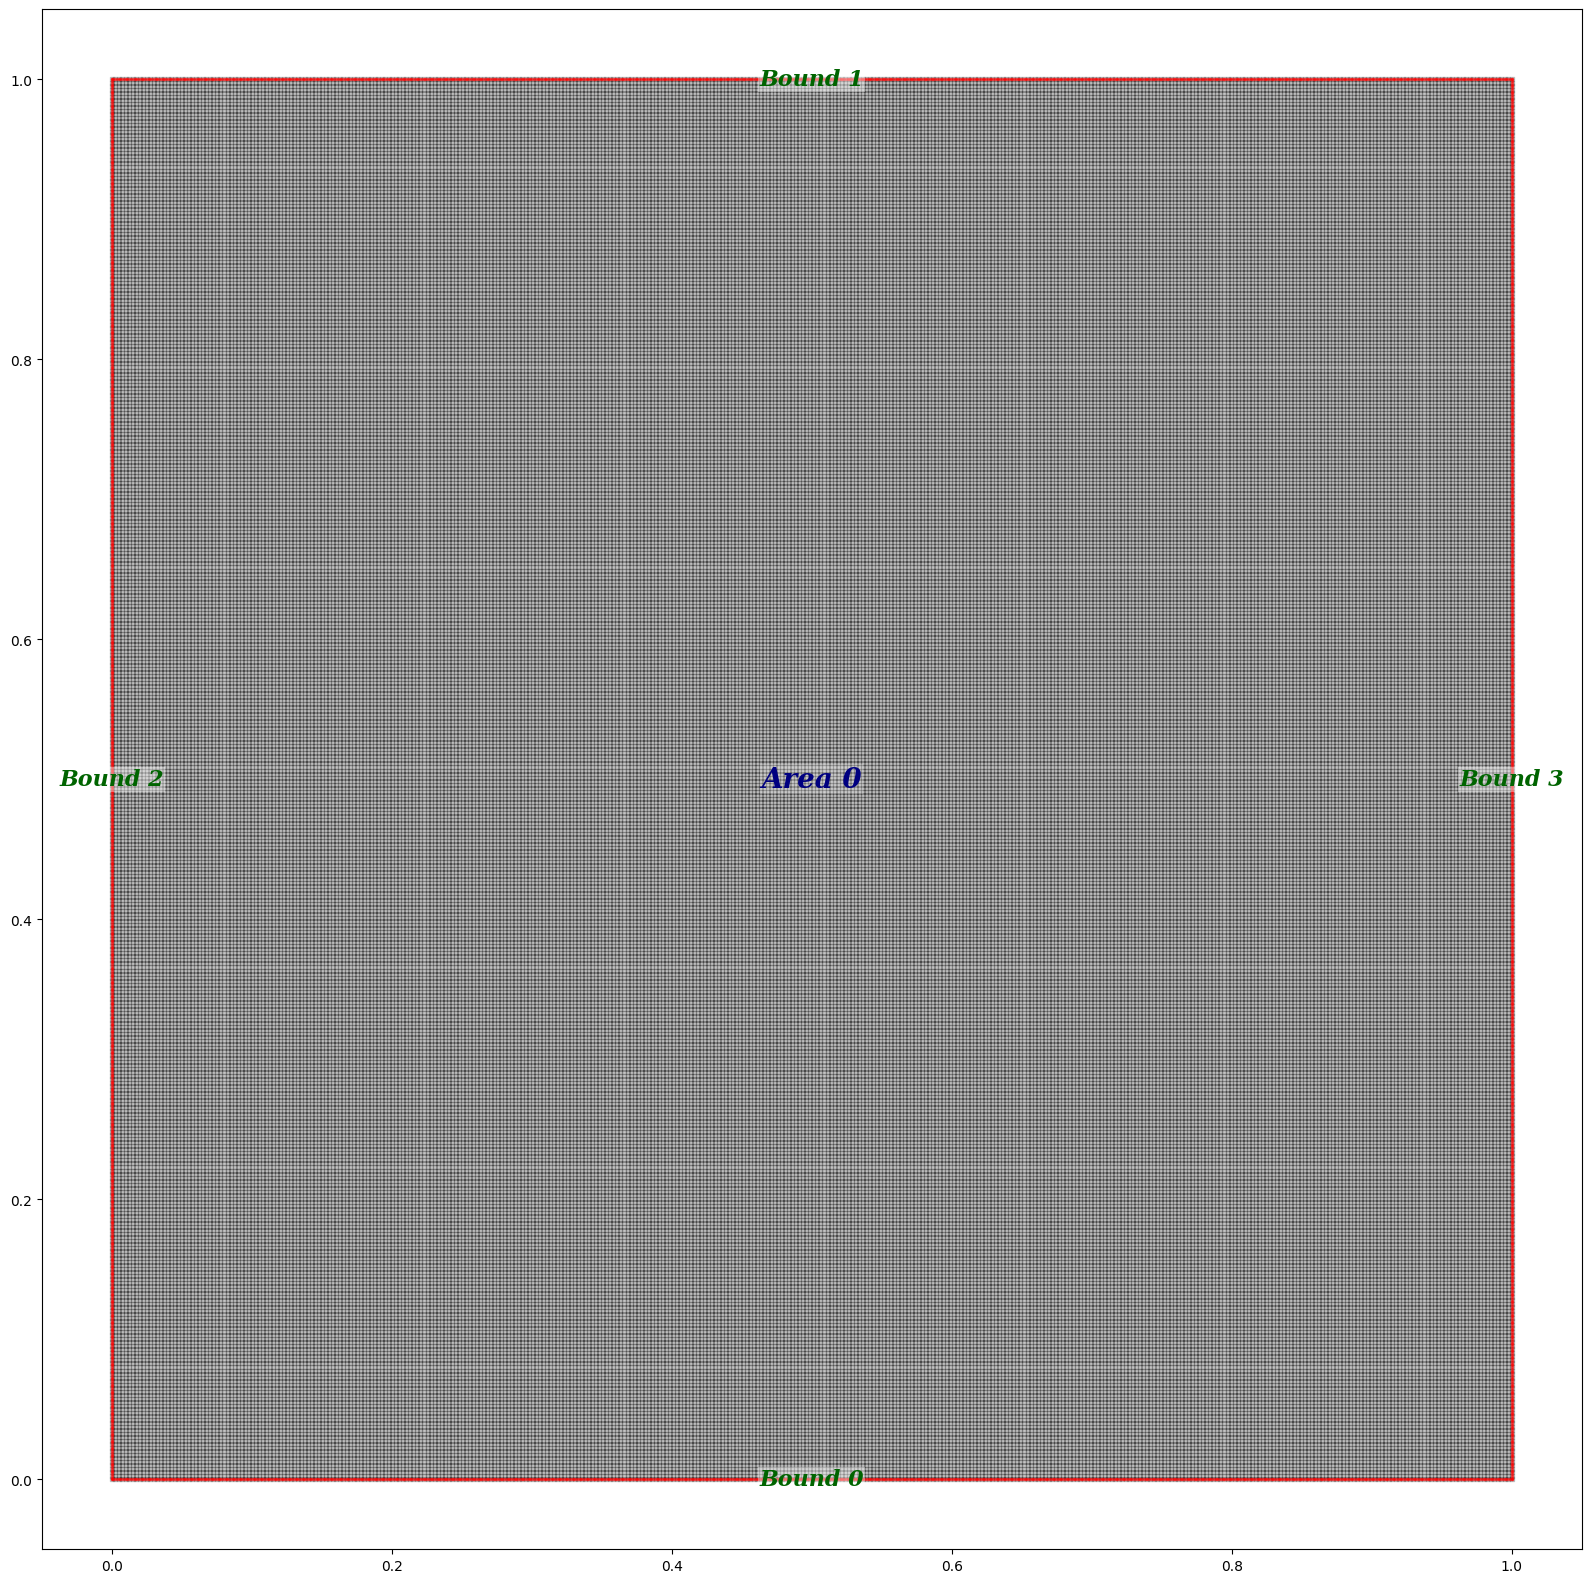

In [95]:
domain = ProblemDomain(bound_list = rectangle.bound_list, area_list = [rectangle], device='cuda')
domain.show_setup()

## 2. Define Physics
Define the Navier-Stokes equations for fluid flow and apply boundary conditions (e.g., no-slip walls, inlet velocity).

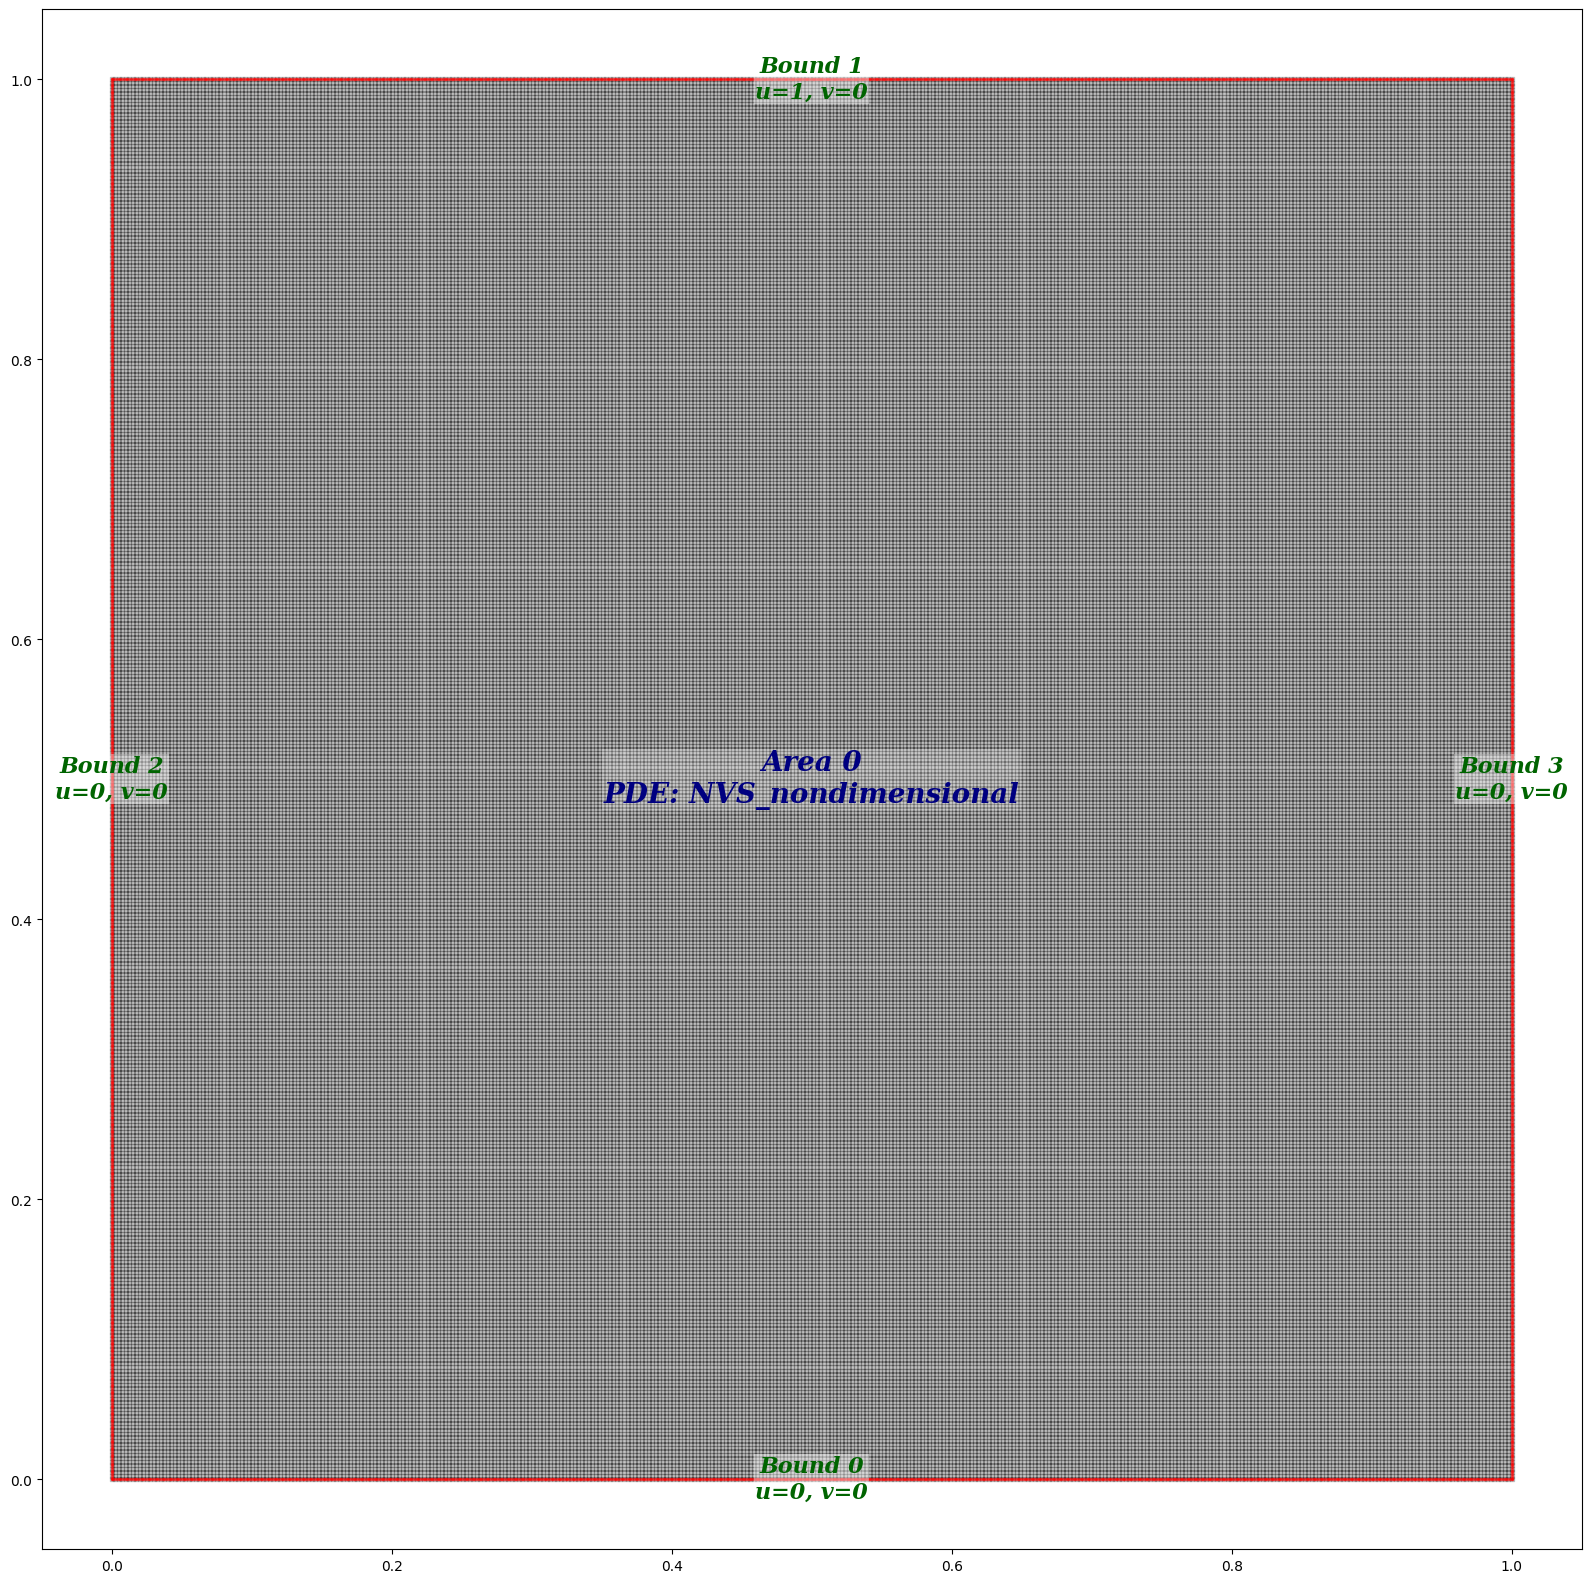

In [96]:
domain.bound_list[0].define_bc({'u':0,'v':0})
domain.bound_list[1].define_bc({'u':1,'v':0})
domain.bound_list[2].define_bc({'u': 0, 'v': 0})
domain.bound_list[3].define_bc({'u': 0, 'v': 0})
domain.area_list[0].define_pde(Physics.NVS_nondimensional(U=0.001, L=1, mu=0.001, rho=1000))
domain.show_setup()


Sample initial points for training. Required if using Residual-based Adaptive Refinement (RAR).

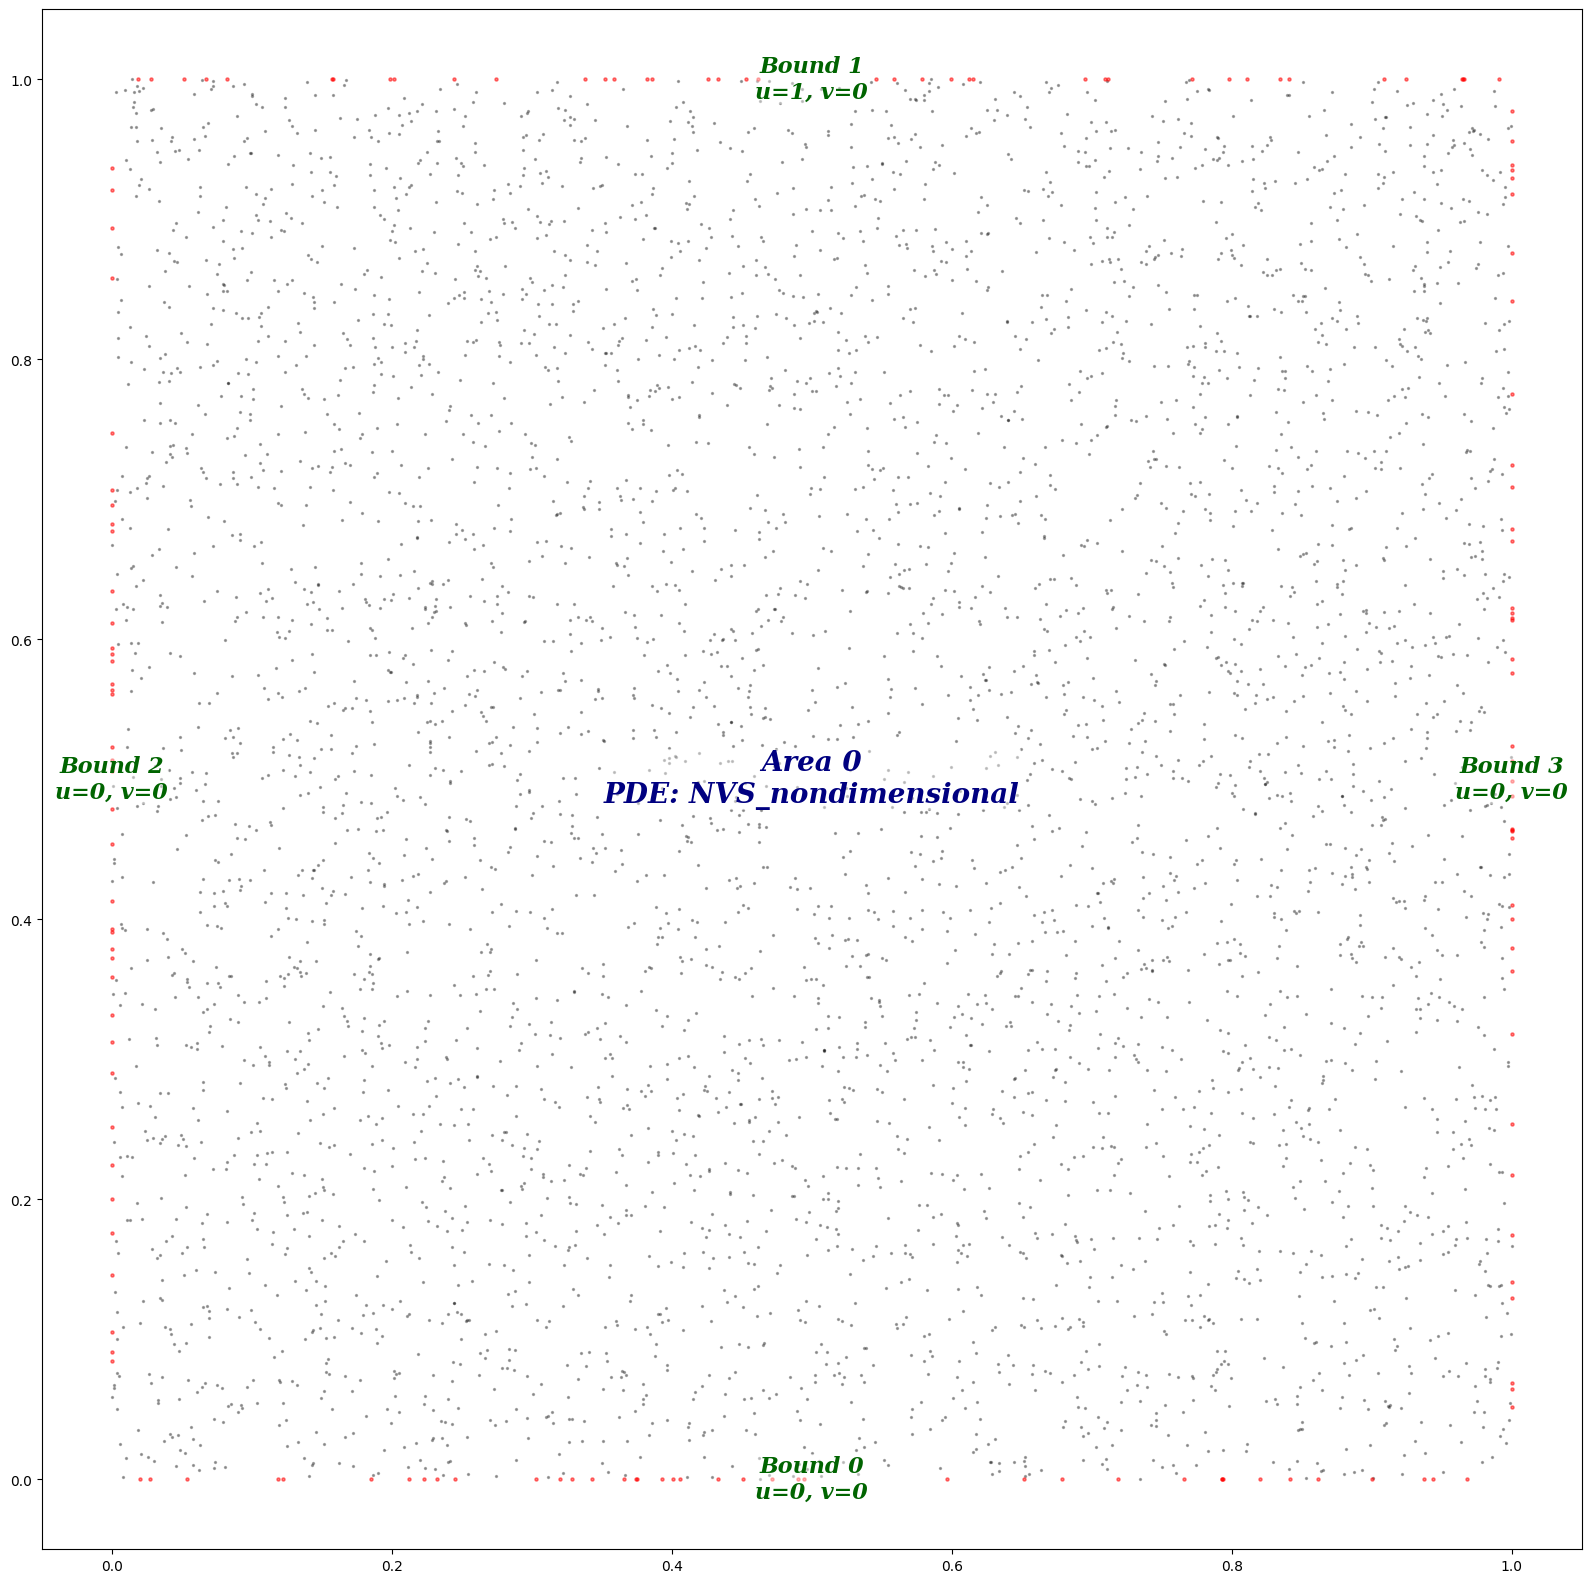

In [97]:
domain.sampling_random_r([40, 40, 40, 40], [5000])
domain.show_coordinates(display_conditions=True)

## 3. Train the PINN model
Initialize a PINN with specified width and depth.

In [98]:
model0 = PINN(width=40, length=8)

Design how to compute loss from boundary conditions and PDE residuals

In [99]:
# Define the loss calculation function
N = 0
def calc_loss(model):
    global N
    N += 1

    # Add collocation points using RAR scheme
    if N % 1000==0:
        domain.sampling_RAR([8, 16, 8, 8], [1000], model, [80, 160, 80, 80], [10000]) #topk: 10% of candidate points
    
    # Resampling collocation points using Random-R scheme (less superior to RAR)
    # if N % 100 == 0:
    #     domain.sampling_random_r([100, 100, 200, 100], [5000])
    # BC Loss
    bc_loss = 0.0
    for i, bc in enumerate(domain.bound_list):
        if i == 1: # if inlet bound
            bc_loss += 2*bc.calc_loss(model)
        else:
            bc_loss += bc.calc_loss(model)

    # PDE Loss
    pde_loss = 0.0
    for i, area in enumerate(domain.area_list):
        pde_loss += area.calc_loss(model)

    # Total Loss
    total_loss = 5*bc_loss + pde_loss # weight bc_loss more

    return {"bc_loss": bc_loss, "pde_loss": pde_loss, "total_loss": total_loss} # MUST RETURN IN THIS FORMAT

Train the model using Adam for initial training (faster convergence).

In [100]:
# Train the model
model1 = NetworkTrainer.train_adam(
    model=model0,
    calc_loss=calc_loss,
    learning_rate=0.001,
    epochs=4000,
    print_every=250,
    threshold_loss=0.02,
    device='cuda'
)

epoch 1, total_loss: 12.06510, bc_loss: 2.41302, pde_loss: 0.00001
epoch 251, total_loss: 0.08268, bc_loss: 0.01515, pde_loss: 0.00694
epoch 501, total_loss: 0.03473, bc_loss: 0.00510, pde_loss: 0.00922
epoch 751, total_loss: 0.03226, bc_loss: 0.00417, pde_loss: 0.01138
epoch 1001, total_loss: 0.31951, bc_loss: 0.05926, pde_loss: 0.02321
epoch 1251, total_loss: 0.28907, bc_loss: 0.05363, pde_loss: 0.02094
epoch 1501, total_loss: 0.26742, bc_loss: 0.04880, pde_loss: 0.02342
epoch 1751, total_loss: 0.22868, bc_loss: 0.04111, pde_loss: 0.02313
epoch 2001, total_loss: 0.34609, bc_loss: 0.06273, pde_loss: 0.03241
epoch 2251, total_loss: 0.37878, bc_loss: 0.06880, pde_loss: 0.03477
epoch 2501, total_loss: 0.29349, bc_loss: 0.05232, pde_loss: 0.03188
epoch 2751, total_loss: 0.42119, bc_loss: 0.07691, pde_loss: 0.03662
epoch 3001, total_loss: 0.32747, bc_loss: 0.06023, pde_loss: 0.02634
epoch 3251, total_loss: 0.32922, bc_loss: 0.06231, pde_loss: 0.01766
epoch 3501, total_loss: 0.29823, bc_los

Refine the model using LBFGS for higher precision.

In [101]:
# Train the model
model2 = NetworkTrainer.train_lbfgs(
    model=model1,
    calc_loss=calc_loss,
    epochs=200,
    print_every=50,
    threshold_loss=0.005,
    device='cuda'
)

epoch 4001, total_loss: 0.31360, bc_loss: 0.05587, pde_loss: 0.03424
epoch 4051, total_loss: 0.28715, bc_loss: 0.05184, pde_loss: 0.02796
epoch 4101, total_loss: 0.30101, bc_loss: 0.05357, pde_loss: 0.03315
epoch 4151, total_loss: 0.28942, bc_loss: 0.05105, pde_loss: 0.03415


Save or Load the model for later use

In [102]:
import pickle
# # Save model with pickle
# with open("model2.pkl", "wb") as f:
#     pickle.dump(model2, f)

# Load model back
# with open("model2.pkl", "rb") as f:
#     model2 = pickle.load(f)

Show the final sampled points used in training

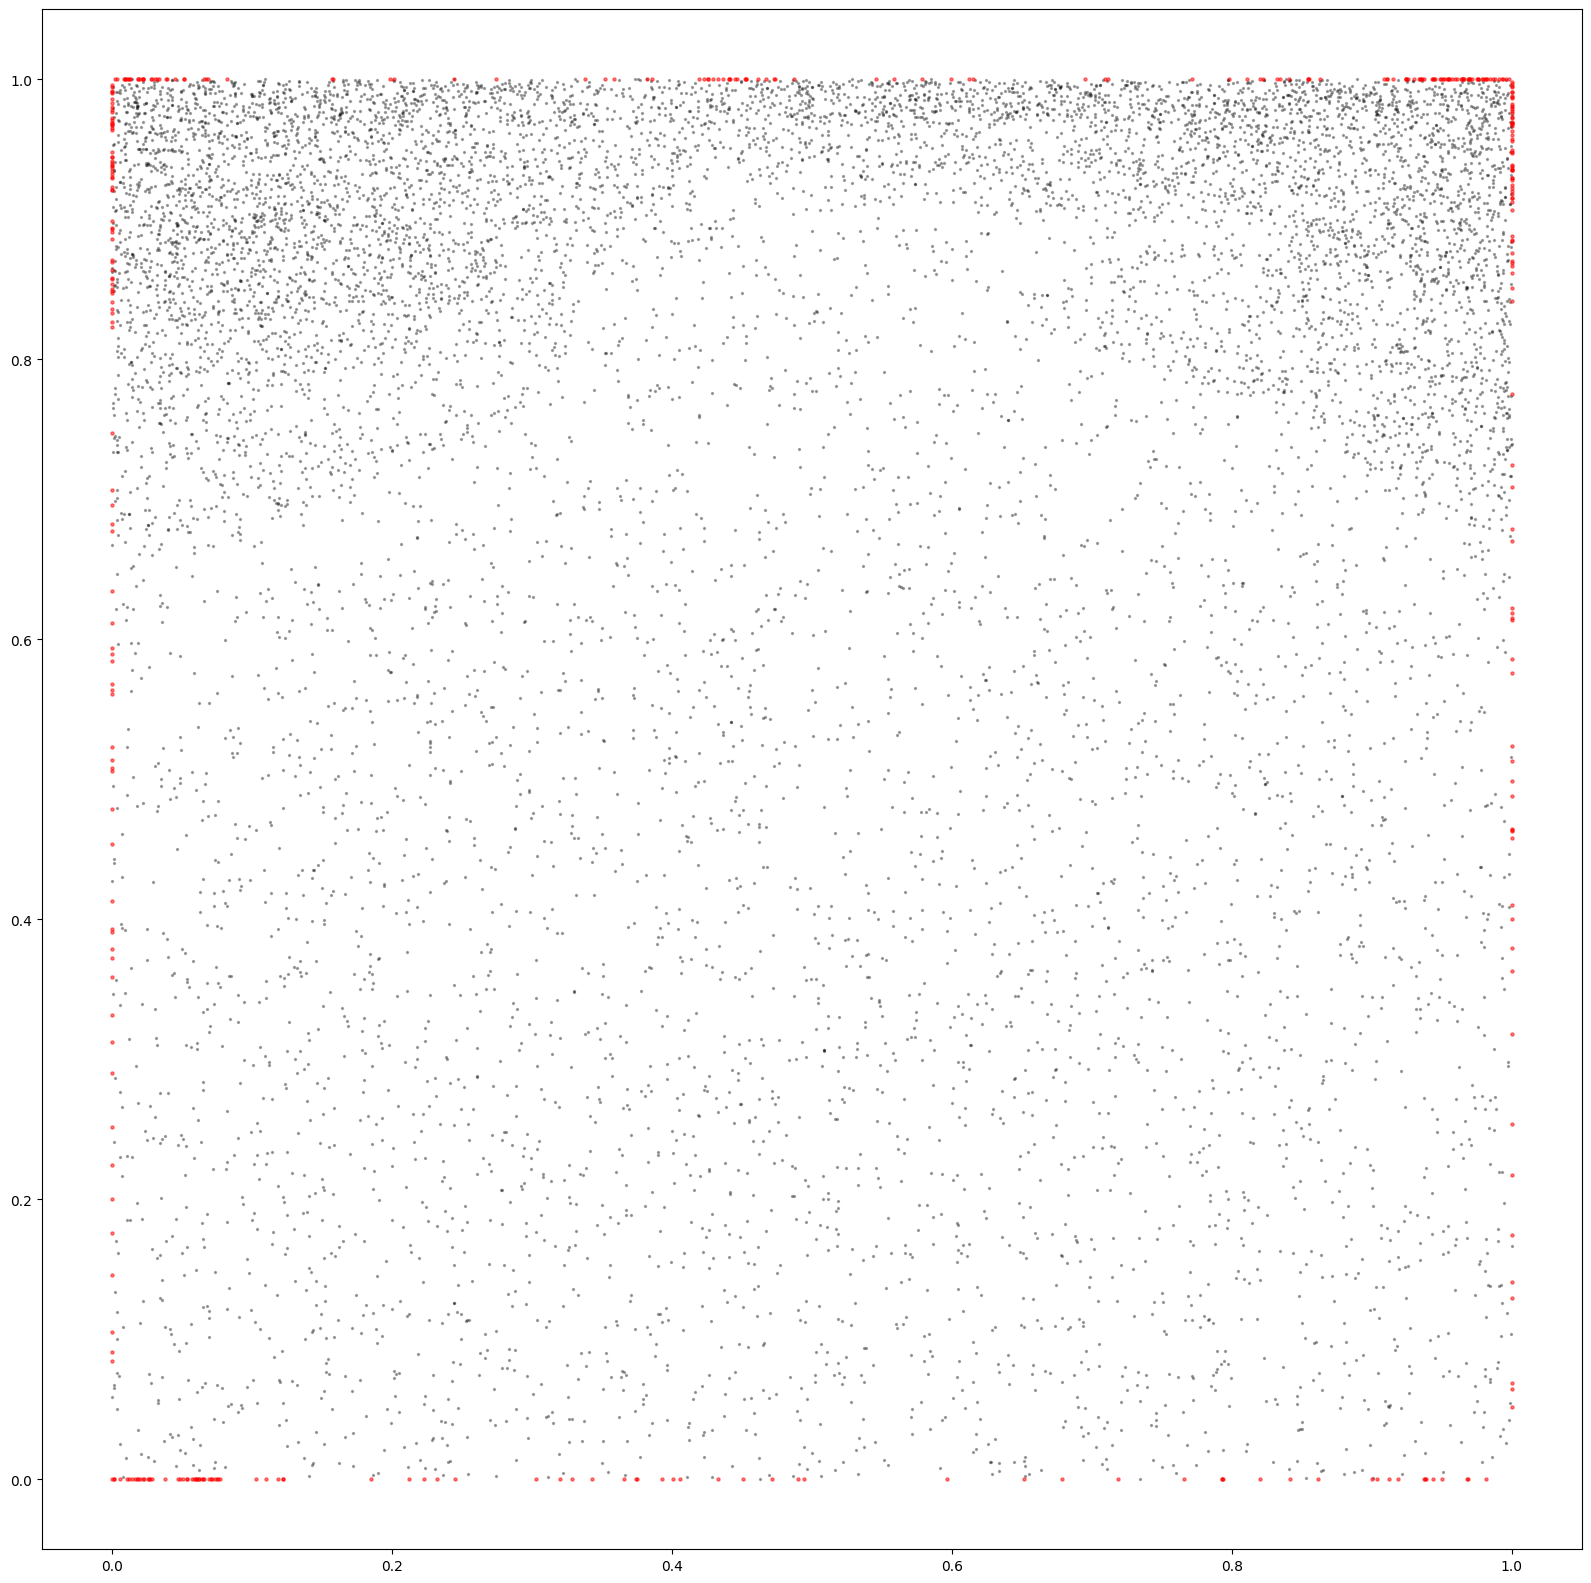

number of bound : 4
        ['0: 88', '1: 136', '2: 88', '3: 88']
        , number of area : 1
        ['0: 11000']


In [103]:
domain.show_coordinates()
print(domain)

## 4. Visualization

### 4.1 Visualize area

In [104]:
# Create object for evaluation (Need Model and Geometry)
area_visual = Evaluate(model2, domain.area_list[0])
# Sampling uniform points
area_visual.sampling_area(100, 100)

available_data: ('u', 'v', 'p', 'velocity_magnitude', 'u_x', 'v_x', 'p_x', 'u_y', 'v_y', 'p_y', 'u_xx', 'v_xx', 'u_yy', 'v_yy', 'PDE residual', 'x', 'y', 'total_loss', 'bc_loss', 'pde_loss')


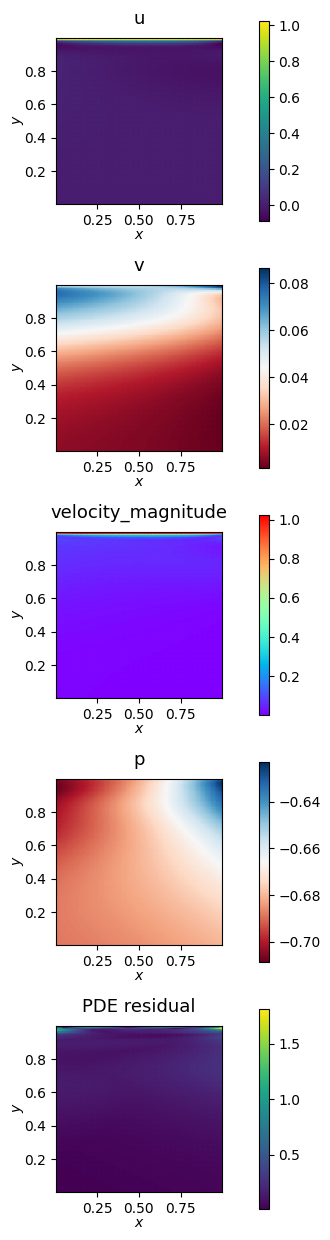

In [105]:
cmap_dict = {
    'u':None,
    'v':'RdBu',
    'velocity_magnitude': 'rainbow',
    'p':'RdBu',
    'PDE residual': 'viridis'
}
colorplot_area_2d = area_visual.plot_data_on_geometry(cmap_dict, s=1)
colorplot_area_2d.savefig('colorplot_area_2d.png')

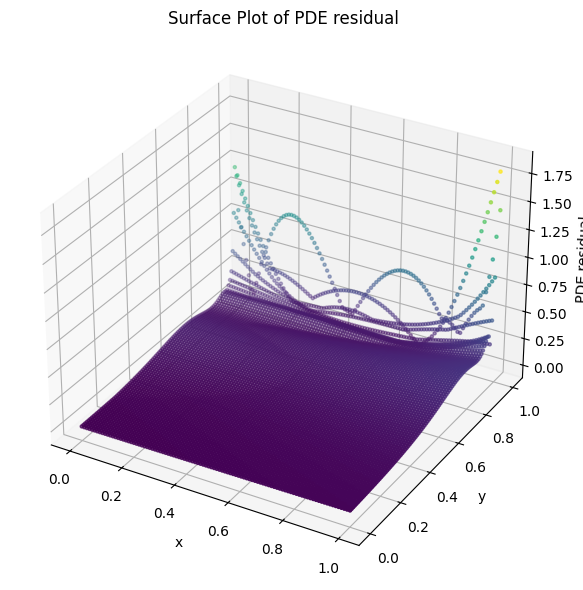

In [106]:
residual_plot_3d = area_visual.plot_data('PDE residual')
residual_plot_3d.savefig('residual_plot_3d.png')

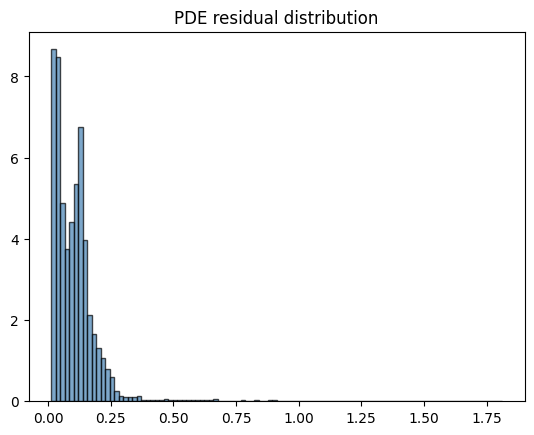

In [107]:
residual_destribution = area_visual.plot_data_distribution('PDE residual', bins=100)

### 4.2 Visualize bound

In [2]:
# Create object for evaluation (Need Model and Geometry)
bound_visual = Evaluate(model2, domain.bound_list[1])
# Sampling uniform points
bound_visual.sampling_line(100)

NameError: name 'Evaluate' is not defined

In [1]:
cmap_dict = {'u':'rainbow','BC residual':None}
colorplot_bound = bound_visual.plot_data_on_geometry(cmap_dict, range_x=[0,1], range_y=[0,1], s=20)
colorplot_bound.savefig('colorplot_bound.png')

NameError: name 'bound_visual' is not defined

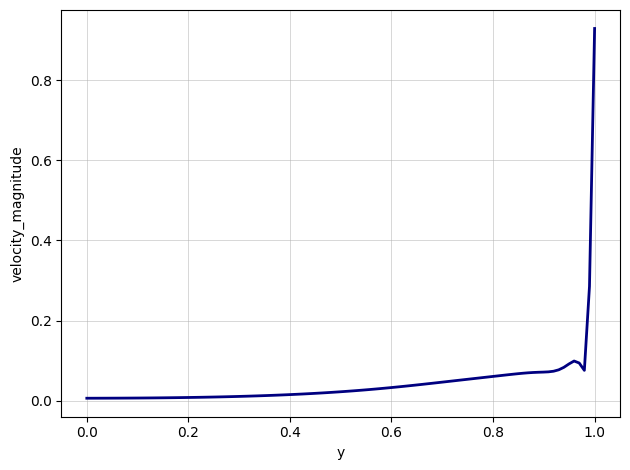

In [110]:
velocity_plot_outlet = bound_visual.plot_data({'velocity_magnitude':'viridis'}, axis='y')
velocity_plot_outlet.savefig('velocity_plot_outlet.png')

## 4.3 Visualize Neural Network data

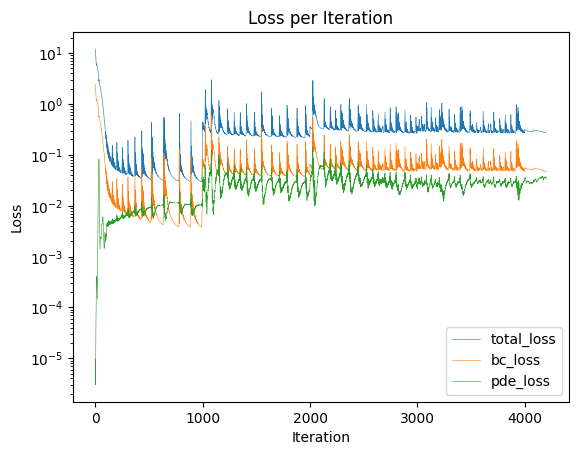

In [111]:
loss_history = bound_visual.plot_loss_curve(log_scale=True, linewidth=0.4)
loss_history.savefig('loss_history.png')

### 4.4 Export data

In [112]:
# display available options
print(bound_visual.data_dict.keys())

dict_keys(['u', 'v', 'p', 'velocity_magnitude', 'BC residual', 'x', 'y', 'total_loss', 'bc_loss', 'pde_loss'])


In [113]:
# store the x,y,velocity_magnitude data
x_data = bound_visual.data_dict['x']
y_data = bound_visual.data_dict['y']
velocity_magnitude_data = bound_visual.data_dict['velocity_magnitude']

#save as txt file
import numpy as np
array = np.column_stack((x_data, y_data, velocity_magnitude_data))
np.savetxt('outlet_velocity_profile.txt', array)